#### Copyright 2019 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Advanced Sequence Prediction

Sequence prediction involves predicting the next value for a given input sequence. Sequence prediction problems are all around us! Some common applications include:
* Weather Forecasting: Given a sequence of observations about the weather over time, predict the weather tomorrow.
* Product Recommendation: Given a sequence of products added to a shopping list by a user, predict the user's next purchase.
* Language Modeling: Given a sequence of words, predict the next word in the sentence.

These problems have been around for a long time, and are often approached using [statistical methods](http://www.statsoft.com/Textbook/Time-Series-Analysis). In recent years, RNNs have gained popularity since they are specially designed to handle sequential input.

In this activity we will use more powerful types of RNNs, a GRU (Gated Recurrent Unit) and an LSTM (Long Short-Term Memory), to perform sequence prediction on stock prices.

## Overview

### Learning Objectives

* Understand and apply RNN models (SimpleRNN, GRU, LSTM)


### Prerequisites

* Neural Networks

### Estimated Duration

40 minutes

### Grading Criteria

Each exercise is worth 3 points. The rubric for calculating those points is:

| Points | Description |
|--------|-------------|
| 0      | No attempt at exercise |
| 1      | Attempted exercise, but code does not run |
| 2      | Attempted exercise, code runs, but produces incorrect answer |
| 3      | Exercise completed successfully |

There is 1 exercise in this Colab so there are 3 points available. The grading scale will be 3 points.

## Data

We will use a generated dataset of stock prices. We will create 10 years of stock data for a fictional company that had an initial public offering (IPO) of $42.

In [2]:
# Set random seeds for reproducible results
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.set_random_seed(42)

In [3]:
days_per_year = 365
years = 10

eod_prices = np.zeros(days_per_year*years)
eod_prices[0] = 42.0

bias = 0.0002

for i in range(1, len(eod_prices)):
  # Find yesterday's price
  yesterdays_price = eod_prices[i-1]
  
  # Generate a random a percentage change on the normal curve.
  percentage_change = np.random.randn(1)[0]
  
  # The random number is a value on the standard normal distribution
  # with a mean 0 and variance 1. This will give us a nice range of
  # positive and negative values, but we need to divide by 100 to scale
  # them down to reasonable percentages for daily stock price changes.
  percentage_change /= 100

  # And finally we give the change just a little bit of positive bias
  # so that we get an interesting curve.
  percentage_change += bias
  
  # Calculate the new price.
  todays_price = yesterdays_price + yesterdays_price * percentage_change
  
  # Store the price.
  eod_prices[i] = todays_price

Let's quickly visualize the data to make sure it looks reasonably realistic.

In [4]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(eod_prices))), eod_prices)
plt.show()

<Figure size 640x480 with 1 Axes>

## Data Preprocessing

RNNs are sensitive to the scale of the input data, specifically when using the `sigmoid` or `tanh` activation functions. It can be good practice to normalize, or rescale the data to a range of 0 to 1. sklearn's [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) is a good tool to perform normalization.

MinMaxScaler expects input of shape `(n_samples, n_features)`. Our data only has one feature (price), so we must reshape it to work with the scaler.

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
# you can use "-1" as a stand-in for one dimension when reshaping NumPy arrays,
# and NumPy will determine the correct value based on the other dimensions.
eod_prices = np.reshape(eod_prices, (-1, 1))
eod_prices = scaler.fit_transform(eod_prices)

eod_prices = np.reshape(eod_prices, -1)
eod_prices[-1]

0.9439132839111171

Notice that the final stock price, around $180, has been normalized to 0.94. We'll use stocks in a 100-day window to predict the next day's stock price.

In [6]:
n_steps = 100
n_samples = len(eod_prices) - n_steps

# split eod_prices into X (100 day windows) and y (next day prices)
X = np.zeros((n_samples, n_steps))
y = np.zeros(n_samples)

for i in range(n_samples):
  X[i] = eod_prices[i:i + n_steps]
  y[i] = eod_prices[i + n_steps]

y[-1]

0.9439132839111171

We need to split a training and testing set. To model real-life forecasting problems, we'll use the stock performance from the first 80% of days as training and the remaining days as testing (modeling predicting the "future").

In [7]:
split_index = int(n_samples * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, X_test.shape

((2840, 100), (710, 100))

## RNN Model in Keras

Keras makes it easy to experiment with different [RNN models](https://keras.io/layers/recurrent/). We will first train a model using a basic RNN to show the basic structure of using an RNN model in Keras.

In [8]:
from tensorflow import keras

RNN models in Keras expect 3-dimensional input with dimensions `(n_samples, n_timesteps, n_features)`. In the documentation, this is described as `(batch_size, timesteps, input_dim)`.

Each of our samples has 100 timesteps and 1 feature (price). We'll need to make `X_train` and `X_test` three dimensional using `np.reshape`. 

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_test.shape

((2840, 100, 1), (710, 100, 1))

### Training

Now let's set up our model. We'll use:

1.   A `SimpleRNN` layer with 25 hidden units (as in the RNN colab).
2.   A `Dense` layer with 1 output unit (the predicted price).

This model is complex enough to converge fairly quickly, so we'll train for 5 epochs and with a batch size of 50. Since this is a regression problem, we'll use [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) as the loss function.

In [10]:
n_units = 25
n_epochs = 5
batch_size = 50

In [11]:
rnn_model = keras.Sequential([
  keras.layers.SimpleRNN(n_units),
  keras.layers.Dense(1)
])

rnn_model.compile(
  loss='mean_squared_error',
  optimizer='adam'
)

W0809 19:39:50.059981 4585104832 deprecation.py:506] From /Users/dorishuang/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
rnn_model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size
)

Epoch 1/5
2840/2840 [==============================] - 2s 780us/sample - loss: 0.0674
Epoch 2/5
2840/2840 [==============================] - 2s 604us/sample - loss: 0.0022
Epoch 3/5
2840/2840 [==============================] - 2s 713us/sample - loss: 0.0013
Epoch 4/5
2840/2840 [==============================] - 2s 800us/sample - loss: 7.4882e-04
Epoch 5/5
2840/2840 [==============================] - 2s 660us/sample - loss: 6.0419e-04


### Testing

Remember that we normalized the data to a 0-1 range before training. To properly evaluate the model, we'll need to un-normalize the predictions, then calculate the Mean Squared Error based on the original data values.

In [13]:
from sklearn.metrics import mean_squared_error

def evaluate(model):
  predicted_train = model.predict(X_train)
  predicted_test = model.predict(X_test)

  # un-normalize predictions
  predicted_train = scaler.inverse_transform(predicted_train)
  predicted_test = scaler.inverse_transform(predicted_test)
  # get original data values
  y_train_raw = scaler.inverse_transform([y_train])[0]
  y_test_raw = scaler.inverse_transform([y_test])[0]
  # calculate mean squared error
  trainScore = mean_squared_error(y_train_raw, predicted_train[:,0])
  print('Train Score: %.2f MSE' % (trainScore))
  testScore = mean_squared_error(y_test_raw, predicted_test[:,0])
  print('Test Score: %.2f MSE' % (testScore))

In [14]:
evaluate(rnn_model)

Train Score: 15.86 MSE
Test Score: 41.67 MSE


## GRU Model

With longer input sequences, RNNs sometimes struggle to "remember" input that they saw earlier in the sequence. The [GRU (Gated Recurrent Unit)](https://arxiv.org/pdf/1406.1078v3.pdf) aims to improve upon this by using an **update gate** and **reset gate** to control what information is kept from previous steps and what is "forgotten". 

We won't get into the details of the architecture here (if you're interested, see the Resources section). What's important to know is that Keras makes it very straightforward to use a GRU instead of an RNN. It's a one-line change!

In [15]:
gru_model = keras.Sequential([
  keras.layers.GRU(n_units), # here's the only change we have to make
  keras.layers.Dense(1)
])

Let's train this GRU model and see how it does. You'll notice that training is slower than with the RNN, due to extra computations needed with the two gates, but the final results should be better due to the GRU capturing more information from previous steps.

In [16]:
gru_model.compile(
  loss='mean_squared_error',
  optimizer='adam'
)

gru_model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size
)

evaluate(gru_model)

W0809 19:40:03.619582 4585104832 deprecation.py:323] From /Users/dorishuang/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
2840/2840 [==============================] - 7s 2ms/sample - loss: 0.0090
Epoch 2/5
2840/2840 [==============================] - 4s 1ms/sample - loss: 1.5136e-04
Epoch 3/5
2840/2840 [==============================] - 3s 1ms/sample - loss: 8.1432e-05
Epoch 4/5
2840/2840 [==============================] - 5s 2ms/sample - loss: 7.8896e-05
Epoch 5/5
2840/2840 [==============================] - 5s 2ms/sample - loss: 7.8093e-05
Train Score: 1.80 MSE
Test Score: 4.11 MSE


## LSTM Model

[LSTM (Long Short Term Memory)](http://www.bioinf.jku.at/publications/older/2604.pdf) networks are even better at learning such long-term dependencies. Similar to GRUs, they also use gates to control information between steps. 

LSTMs use an explicit **cell state** to control this information flow, which interacts with the **hidden state** that we're used to thinking about. An **input gate**, **forget gate**, and **output gate** control how we update the cell state at each step.

Again, don't worry too much about the specifics for now (and see Resources if you're interested)! We only need to change one line to use an LSTM instead.

In [17]:
lstm_model = keras.Sequential([
  keras.layers.LSTM(n_units), # the magic change
  keras.layers.Dense(1)
])

In [18]:
lstm_model.compile(
  loss='mean_squared_error',
  optimizer='adam'
)

lstm_model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size
)

evaluate(lstm_model)

Epoch 1/5
2840/2840 [==============================] - 5s 2ms/sample - loss: 0.1196
Epoch 2/5
2840/2840 [==============================] - 6s 2ms/sample - loss: 0.0049
Epoch 3/5
2840/2840 [==============================] - 5s 2ms/sample - loss: 7.8645e-04
Epoch 4/5
2840/2840 [==============================] - 5s 2ms/sample - loss: 4.8342e-04
Epoch 5/5
2840/2840 [==============================] - 4s 2ms/sample - loss: 3.9070e-04
Train Score: 8.60 MSE
Test Score: 14.92 MSE


LSTM models usually take the longest to train (due to needing the most computations). They are also usually the most powerful, though they may need more epochs to converge.

In practice, it's a good idea to start with an RNN and then upgrade to either a GRU or LSTM if you need a more complex model. For very long input sequences, LSTMs typically work better at capturing the longer-term dependencies in the sequence.

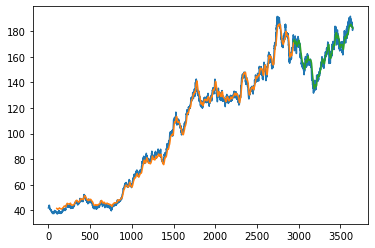

In [19]:
# Visualize LSTM predictions

predicted_train = lstm_model.predict(X_train)
predicted_test = lstm_model.predict(X_test)

# un-normalize predictions
predicted_train = scaler.inverse_transform(predicted_train)
predicted_test = scaler.inverse_transform(predicted_test)

plt.plot(range(len(eod_prices)), scaler.inverse_transform([eod_prices])[0])
plt.plot(range(n_steps, len(predicted_train) + n_steps), predicted_train)
plt.plot(range(len(predicted_train) + n_steps, len(eod_prices)), predicted_test)
plt.show()

## Extensions

There are many more [complex RNN models](https://keras.io/layers/recurrent/) you can use, as well as complex techniques such as bi-directional RNNs (considering a sequence in the forward and backward directions) and stacked RNNs (feeding the output of one RNN into another). For most of these, most of the coding work happens in processing data and building the general training / testing logic. Switching the exact RNN model you use is often only a one- or few-line change. 

There are also many problems involving input sequences that go beyond sequence prediction -- for example, you could generate multiple predictions, classification results, or even full sequences. For longer and longer sequences, RNNs are even being overshadowed by a new technique called [Transformers](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html). the field of deep learning is ever growing and expanding -- part of what makes it so exciting to study :-)

# Resources

*   https://colah.github.io/posts/2015-08-Understanding-LSTMs/
*   https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be



# Exercises

## Exercise 1

Your turn! Train a GRU or LSTM model on a dataset of your choice. Visualize its performance and compare its performance to a basic RNN model.

### Student Solution

In [21]:
import numpy as np 
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# https://datahub.io/core/global-temp#resource-global-temp_zip
filename = './monthly_csv.csv'
#weather =pd.read_csv(filename)

weather = pd.read_csv("https://datahub.io/core/global-temp/r/monthly.csv")

In [22]:
weather = weather.loc[weather['Source'] == 'GCAG']
weather= weather.sort_index(ascending=False, axis=0)
mean_temp = weather['Mean'].tolist()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-10, 10))
mean_temp = np.reshape(mean_temp, (-1, 1))
mean_temp = scaler.fit_transform(mean_temp)

mean_temp = np.reshape(mean_temp, -1)
mean_temp

array([-2.85226616, -4.15261803, -4.28706476, ...,  4.79754215,
        5.02021953,  5.43091224])

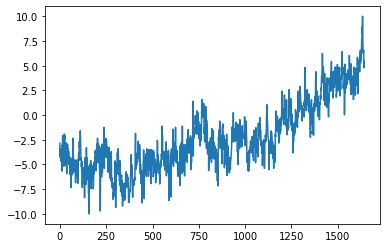

In [23]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(mean_temp))), mean_temp)
plt.show()

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
# you can use "-1" as a stand-in for one dimension when reshaping NumPy arrays,
# and NumPy will determine the correct value based on the other dimensions.
mean_temp_scale = np.reshape(mean_temp, (-1, 1))
mean_temp_scale = scaler.fit_transform(mean_temp_scale)

mean_temp_scale = np.reshape(mean_temp_scale, -1)

n_steps = 120
n_samples = len(mean_temp_scale) - n_steps

# split eod_prices into X (100 day windows) and y (next day prices)
X = np.zeros((n_samples, n_steps))
y = np.zeros(n_samples)

for i in range(n_samples):
  X[i] = mean_temp_scale[i:i + n_steps]
  y[i] = mean_temp_scale[i + n_steps]


In [25]:
split_index = int(n_samples * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, X_test.shape

((1219, 120), (305, 120))

In [26]:
from tensorflow import keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_test.shape

((1219, 120, 1), (305, 120, 1))

In [27]:
from sklearn.metrics import mean_squared_error

def evaluate(model):
  predicted_train = model.predict(X_train)
  predicted_test = model.predict(X_test)

  # un-normalize predictions
  predicted_train = scaler.inverse_transform(predicted_train)
  predicted_test = scaler.inverse_transform(predicted_test)
  # get original data values
  y_train_raw = scaler.inverse_transform([y_train])[0]
  y_test_raw = scaler.inverse_transform([y_test])[0]
  # calculate mean squared error
  trainScore = mean_squared_error(y_train_raw, predicted_train[:,0])
  print('Train Score: %.2f MSE' % (trainScore))
  testScore = mean_squared_error(y_test_raw, predicted_test[:,0])
  print('Test Score: %.2f MSE' % (testScore))

In [28]:
n_units = 36
n_epochs = 5
batch_size = 50

rnn_model = keras.Sequential([
  keras.layers.SimpleRNN(n_units),
  keras.layers.Dense(1)
])

rnn_model.compile(
  loss='mean_squared_error',
  optimizer='adam'
)

rnn_model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size
)

evaluate(rnn_model)

Epoch 1/5
1219/1219 [==============================] - 1s 883us/sample - loss: 0.0782
Epoch 2/5
1219/1219 [==============================] - 1s 425us/sample - loss: 0.0177
Epoch 3/5
1219/1219 [==============================] - 1s 426us/sample - loss: 0.0097
Epoch 4/5
1219/1219 [==============================] - 1s 701us/sample - loss: 0.0060
Epoch 5/5
1219/1219 [==============================] - 1s 556us/sample - loss: 0.0050
Train Score: 1.88 MSE
Test Score: 6.57 MSE


In [29]:
lstm_model = keras.Sequential([
  keras.layers.LSTM(n_units), # the magic change
  keras.layers.Dense(1)
])

lstm_model.compile(
  loss='mean_squared_error',
  optimizer='adam'
)

lstm_model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size
)

evaluate(lstm_model)

Epoch 1/5
1219/1219 [==============================] - 3s 2ms/sample - loss: 0.0444
Epoch 2/5
1219/1219 [==============================] - 2s 2ms/sample - loss: 0.0057
Epoch 3/5
1219/1219 [==============================] - 3s 2ms/sample - loss: 0.0045
Epoch 4/5
1219/1219 [==============================] - 2s 2ms/sample - loss: 0.0041
Epoch 5/5
1219/1219 [==============================] - 3s 2ms/sample - loss: 0.0037
Train Score: 1.44 MSE
Test Score: 1.91 MSE


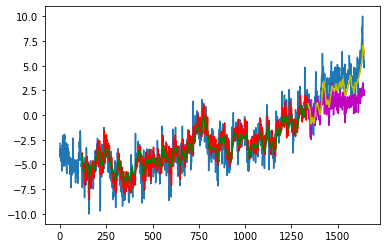

In [30]:
# Visualize LSTM predictions
rnn_predicted_train = rnn_model.predict(X_train)
rnn_predicted_test = rnn_model.predict(X_test)
  
lstm_predicted_train = lstm_model.predict(X_train)
lstm_predicted_test = lstm_model.predict(X_test)

# un-normalize predictions
rnn_predicted_train = scaler.inverse_transform(rnn_predicted_train)
rnn_predicted_test = scaler.inverse_transform(rnn_predicted_test)
lstm_predicted_train = scaler.inverse_transform(lstm_predicted_train)
lstm_predicted_test = scaler.inverse_transform(lstm_predicted_test)

plt.plot(range(len(mean_temp_scale)), scaler.inverse_transform([mean_temp_scale])[0])
plt.plot(range(n_steps, len(rnn_predicted_train) + n_steps), rnn_predicted_train,'r')
plt.plot(range(len(rnn_predicted_train) + n_steps, len(mean_temp_scale)), rnn_predicted_test,'m')
plt.plot(range(n_steps, len(lstm_predicted_train) + n_steps), lstm_predicted_train,'g')
plt.plot(range(len(lstm_predicted_train) + n_steps, len(mean_temp_scale)), lstm_predicted_test,'y')
plt.show()